+ training và đánh giá model.

In [ ]:
import torch  # Nhập mô-đun PyTorch
import torch.nn as nn  # Nhập mô-đun Neural Network từ PyTorch
import torch.nn.functional as F  # Nhập các hàm chức năng cho neural network
import torch.optim as optim  # Nhập mô-đun tối ưu hóa từ PyTorch
import torchvision  # Nhập mô-đun torchvision để xử lý ảnh
import torchvision.transforms as transforms  # Nhập các phép biến đổi cho ảnh
from torch.optim.lr_scheduler import StepLR  # Nhập scheduler giảm tốc độ học
from sklearn.metrics import precision_score, recall_score, accuracy_score  # Nhập các hàm tính toán độ chính xác

# Định nghĩa các phép biến đổi cho tập huấn luyện
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Lật ảnh theo chiều ngang ngẫu nhiên
    transforms.RandomCrop(32, padding=4),  # Cắt ngẫu nhiên với kích thước 32x32 và padding 4
    transforms.ToTensor(),  # Chuyển đổi ảnh thành tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa ảnh
])

# Định nghĩa các phép biến đổi cho tập kiểm tra
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Chuyển đổi ảnh thành tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa ảnh
])

# Tạo tập dữ liệu huấn luyện từ CIFAR10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
# Tạo loader cho tập dữ liệu huấn luyện
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Tạo tập dữ liệu kiểm tra từ CIFAR10
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
# Tạo loader cho tập dữ liệu kiểm tra
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# CIFAR-10 có 60,000 ảnh tổng cộng, trong đó:
# 50,000 ảnh trong tập huấn luyện
# 10,000 ảnh trong tập kiểm tra

# Định nghĩa lớp mô hình
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # Khởi tạo lớp cơ sở
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Lớp tích chập đầu tiên
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Lớp tích chập thứ hai
        self.pool = nn.MaxPool2d(2, 2)  # Lớp max pooling
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Lớp fully connected đầu tiên
        self.fc2 = nn.Linear(512, 10)  # Lớp fully connected thứ hai
        self.dropout = nn.Dropout(0.5)  # Lớp dropout để giảm overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Thực hiện tích chập và pooling
        x = self.pool(F.relu(self.conv2(x)))  # Thực hiện tích chập và pooling
        x = x.view(-1, 64 * 8 * 8)  # Chuyển đổi tensor thành dạng 2D
        x = F.relu(self.fc1(x))  # Thực hiện lớp fully connected đầu tiên
        x = self.dropout(x)  # Áp dụng dropout
        x = self.fc2(x)  # Thực hiện lớp fully connected thứ hai
        return x  # Trả về đầu ra

# Tạo một thể hiện của mô hình
model = Net()
# Chọn thiết bị để chạy mô hình (GPU nếu có, ngược lại là CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Chuyển mô hình sang thiết bị đã chọn

# Định nghĩa hàm mất mát
criterion = nn.CrossEntropyLoss()
# Định nghĩa bộ tối ưu hóa Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Định nghĩa scheduler để giảm tốc độ học sau mỗi 5 epoch
scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

n_epochs = 10  # Số lượng epoch huấn luyện
train_losses = []  # Danh sách lưu trữ giá trị mất mát trong quá trình huấn luyện
train_accuracies = []  # Danh sách lưu trữ độ chính xác trong quá trình huấn luyện
test_losses = []  # Danh sách lưu trữ giá trị mất mát trong quá trình kiểm tra
test_accuracies = []  # Danh sách lưu trữ độ chính xác trong quá trình kiểm tra

# Hàm đánh giá mô hình
def evaluate(model, dataloader, loss_fn):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    test_loss = 0.0  # Khởi tạo giá trị mất mát kiểm tra
    correct = 0  # Khởi tạo số lượng dự đoán đúng
    total = 0  # Khởi tạo tổng số mẫu

    with torch.no_grad():  # Không tính toán gradient trong quá trình đánh giá
        for inputs, labels in dataloader:  # Lặp qua các batch trong dataloader
            inputs, labels = inputs.to(device), labels.to(device)  # Chuyển dữ liệu sang thiết bị
            outputs = model(inputs)  # Dự đoán đầu ra từ mô hình
            loss = loss_fn(outputs, labels)  # Tính toán mất mát
            test_loss += loss.item()  # Cộng dồn giá trị mất mát
            _, predicted = torch.max(outputs.data, 1)  # Lấy nhãn dự đoán
            total += labels.size(0)  # Cộng dồn tổng số mẫu
            correct += (predicted == labels).sum().item()  # Cập nhật số lượng dự đoán đúng

    accuracy = 100 * correct / total  # Tính toán độ chính xác
    test_loss /= len(dataloader)  # Tính trung bình mất mát
    return test_loss, accuracy  # Trả về mất mát và độ chính xác

best_accuracy = 0.0  # Khởi tạo giá trị độ chính xác tốt nhất

# Vòng lặp huấn luyện qua từng epoch
# "epoch" chỉ một lần lặp qua toàn bộ tập dữ liệu trong quá trình huấn luyện mô hình
for epoch in range(n_epochs):
    model.train()  # Chuyển mô hình sang chế độ huấn luyện
    running_loss = 0.0  # Khởi tạo giá trị mất mát trong epoch
    running_correct = 0  # Khởi tạo số lượng dự đoán đúng
    total = 0  # Khởi tạo tổng số mẫu

    for i, (inputs, labels) in enumerate(trainloader, 0):  # Lặp qua các batch trong trainloader
        inputs, labels = inputs.to(device), labels.to(device)  # Chuyển dữ liệu sang thiết bị

        optimizer.zero_grad()  # Đặt gradient về 0 trước khi tính toán

        outputs = model(inputs)  # Dự đoán đầu ra từ mô hình
        loss = criterion(outputs, labels)  # Tính toán mất mát
        loss.backward()  # Tính toán gradient
        optimizer.step()  # Cập nhật tham số của mô hình

        running_loss += loss.item()  # Cộng dồn giá trị mất mát

        _, predicted = torch.max(outputs.data, 1)  # Lấy nhãn dự đoán
        total += labels.size(0)  # Cộng dồn tổng số mẫu
        running_correct += (predicted == labels).sum().item()  # Cập nhật số lượng dự đoán đúng

    epoch_accuracy = 100 * running_correct / total  # Tính toán độ chính xác của epoch
    epoch_loss = running_loss / (i + 1)  # Tính trung bình mất mát của epoch
    test_loss, test_accuracy = evaluate(model, testloader, criterion)  # Đánh giá mô hình trên tập kiểm tra
    
    # In ra kết quả của epoch
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)  # Lưu giá trị mất mát của epoch
    train_accuracies.append(epoch_accuracy)  # Lưu độ chính xác của epoch
    test_losses.append(test_loss)  # Lưu giá trị mất mát kiểm tra
    test_accuracies.append(test_accuracy)  # Lưu độ chính xác kiểm tra

    if test_accuracy > best_accuracy:  # Nếu độ chính xác kiểm tra tốt hơn độ chính xác tốt nhất
        best_accuracy = test_accuracy  # Cập nhật độ chính xác tốt nhất
        torch.save(model.state_dict(), 'best_model.pth')  # Lưu mô hình

    scheduler.step()  # Cập nhật tốc độ học theo scheduler

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.6335, Accuracy: 40.07%, Test Loss: 1.2612, Test Accuracy: 54.78%
Epoch [2/10], Loss: 1.3078, Accuracy: 52.72%, Test Loss: 1.0581, Test Accuracy: 62.20%
Epoch [3/10], Loss: 1.1683, Accuracy: 57.87%, Test Loss: 0.9483, Test Accuracy: 66.40%
Epoch [4/10], Loss: 1.0808, Accuracy: 61.55%, Test Loss: 0.8731, Test Accuracy: 68.89%
Epoch [5/10], Loss: 1.0210, Accuracy: 63.49%, Test Loss: 0.8714, Test Accuracy: 68.92%
Epoch [6/10], Loss: 0.9390, Accuracy: 66.71%, Test Loss: 0.7931, Test Accuracy: 72.01%
Epoch [7/10], Loss: 0.9185, Accuracy: 67.73%, Test Loss: 0.7805, Test Accuracy: 72.49%
Epoch [8/10], Loss: 0.9035, Accuracy: 68.18%, Test Loss: 0.7684, Test Accuracy: 72.86%
Epoch [9/10], Loss: 0.8887, Accuracy: 68.87%, Test Loss: 0.7603, Test Accuracy: 73.06%
Epoch [10/10], Loss: 0.8812, Accuracy: 68.92%, Test Loss: 0.7541, Test Accuracy: 73.47%


+ Biểu đồ sau khi train

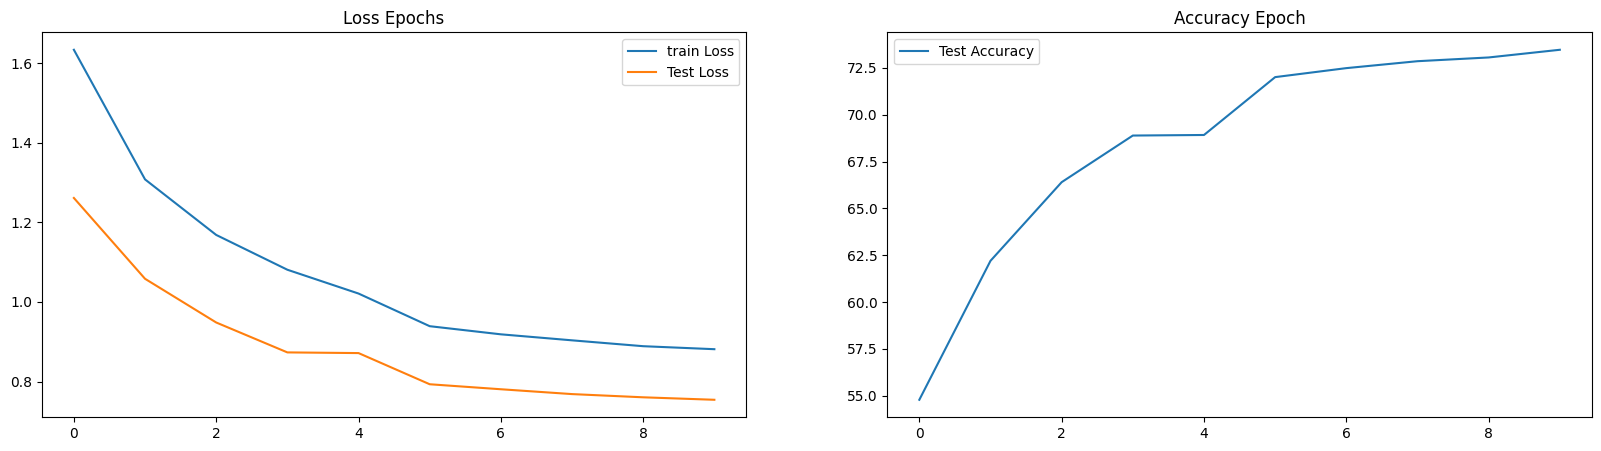

In [ ]:
import matplotlib.pyplot as plt  # Nhập mô-đun matplotlib để vẽ biểu đồ

plt.figure(figsize=(20, 5))  # Tạo một figure với kích thước 20x5 inch

# Tạo subplot cho biểu đồ mất mát
plt.subplot(121)  # Chọn vị trí subplot đầu tiên (1 hàng, 2 cột, vị trí 1)
plt.title('Loss Epochs')  # Đặt tiêu đề cho biểu đồ mất mát
plt.plot(train_losses, label='train Loss')  # Vẽ đường biểu diễn cho mất mát huấn luyện
plt.plot(test_losses, label='Test Loss')  # Vẽ đường biểu diễn cho mất mát kiểm tra
plt.legend()  # Hiện thị chú thích cho các đường biểu diễn

# Tạo subplot cho biểu đồ độ chính xác
plt.subplot(122)  # Chọn vị trí subplot thứ hai (1 hàng, 2 cột, vị trí 2)
plt.title('Accuracy Epoch')  # Đặt tiêu đề cho biểu đồ độ chính xác
plt.plot(test_accuracies, label='Test Accuracy')  # Vẽ đường biểu diễn cho độ chính xác kiểm tra
plt.legend()  # Hiện thị chú thích cho đường biểu diễn

plt.show()  # Hiển thị tất cả các biểu đồ đã vẽ

+ Thuật toán SVM (Support Vector Machine) là một phương pháp học máy được sử dụng chủ yếu cho các bài toán phân loại và hồi quy

In [ ]:
import torch  # Nhập mô-đun PyTorch
import torchvision  # Nhập mô-đun torchvision để xử lý ảnh
import torchvision.transforms as transforms  # Nhập các phép biến đổi cho ảnh
from sklearn import svm  # Nhập mô-đun SVM từ sklearn
from sklearn.ensemble import RandomForestClassifier  # Nhập mô-đun RandomForest (chưa sử dụng trong đoạn này)
from sklearn.metrics import precision_score, recall_score  # Nhập các hàm tính toán precision và recall
import numpy as np  # Nhập mô-đun numpy để xử lý mảng

# Chuyển đổi dữ liệu huấn luyện thành định dạng numpy
for data in trainloader:  # Lặp qua từng batch trong trainloader
    train_images, train_labels = data  # Tách dữ liệu và nhãn
    train_images = train_images.view(train_images.size(0), -1).numpy()  # Biến đổi tensor thành mảng 2D
    train_labels = train_labels.numpy()  # Chuyển nhãn thành mảng numpy

# Chuyển đổi dữ liệu kiểm tra thành định dạng numpy
for data in testloader:  # Lặp qua từng batch trong testloader
    test_images, test_labels = data  # Tách dữ liệu và nhãn
    test_images = test_images.view(test_images.size(0), -1).numpy()  # Biến đổi tensor thành mảng 2D
    test_labels = test_labels.numpy()  # Chuyển nhãn thành mảng numpy

# Định nghĩa mô hình SVM với kernel tuyến tính
svm_model = svm.SVC(kernel='linear', C=1.0)  # Tạo một mô hình SVM với kernel tuyến tính

# Huấn luyện mô hình SVM với dữ liệu huấn luyện
svm_model.fit(train_images, train_labels)  # Huấn luyện mô hình trên dữ liệu huấn luyện

# Dự đoán nhãn cho tập kiểm tra
svm_predictions = svm_model.predict(test_images)  # Dự đoán nhãn cho dữ liệu kiểm tra

# Tính toán Precision và Recall
svm_precision = precision_score(test_labels, svm_predictions, average='macro') * 100  # Tính precision
svm_recall = recall_score(test_labels, svm_predictions, average='macro') * 100  # Tính recall

# In ra kết quả Precision và Recall
print(f'SVM Precision: {svm_precision:.2f}%')  # In ra giá trị precision
print(f'SVM Recall: {svm_recall:.2f}%')  # In ra giá trị recall

SVM Precision: 22.50%
SVM Recall: 20.00%


C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+ Thuật toán Random Forest là một thuật toán học máy sử dụng để phân loại và hồi quy, dựa trên nguyên lý của cây quyết định (decision trees).

In [ ]:
import torch  # Nhập mô-đun PyTorch
import torchvision  # Nhập mô-đun torchvision để xử lý ảnh
import torchvision.transforms as transforms  # Nhập các phép biến đổi cho ảnh
from sklearn.ensemble import RandomForestClassifier  # Nhập mô-đun RandomForestClassifier từ sklearn
from sklearn.metrics import precision_score, recall_score  # Nhập các hàm tính toán precision và recall
import numpy as np  # Nhập mô-đun numpy để xử lý mảng

# Chuyển đổi dữ liệu huấn luyện thành định dạng numpy
for data in trainloader:  # Lặp qua từng batch trong trainloader
    train_images, train_labels = data  # Tách dữ liệu và nhãn
    train_images = train_images.view(train_images.size(0), -1).numpy()  # Biến đổi tensor thành mảng 2D
    train_labels = train_labels.numpy()  # Chuyển nhãn thành mảng numpy

# Chuyển đổi dữ liệu kiểm tra thành định dạng numpy
for data in testloader:  # Lặp qua từng batch trong testloader
    test_images, test_labels = data  # Tách dữ liệu và nhãn
    test_images = test_images.view(test_images.size(0), -1).numpy()  # Biến đổi tensor thành mảng 2D
    test_labels = test_labels.numpy()  # Chuyển nhãn thành mảng numpy

# Định nghĩa mô hình Random Forest với 100 cây
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Tạo mô hình Random Forest

# Huấn luyện mô hình Random Forest với dữ liệu huấn luyện
rf_model.fit(train_images, train_labels)  # Huấn luyện mô hình trên dữ liệu huấn luyện

# Dự đoán nhãn cho tập kiểm tra
rf_predictions = rf_model.predict(test_images)  # Dự đoán nhãn cho dữ liệu kiểm tra

# Tính toán Precision và Recall
rf_precision = precision_score(test_labels, rf_predictions, average='macro') * 100  # Tính precision
rf_recall = recall_score(test_labels, rf_predictions, average='macro') * 100  # Tính recall

# In ra kết quả Precision và Recall
print(f'Random Forest Precision: {rf_precision:.2f}%')  # In ra giá trị precision
print(f'Random Forest Recall: {rf_recall:.2f}%')  # In ra giá trị recall

Random Forest Precision: 5.56%
Random Forest Recall: 7.41%


C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+ Thuật toán CNN (Mạng Nơ-ron Tích chập) là một loại mạng nơ-ron được thiết kế đặc biệt cho việc xử lý và phân tích dữ liệu có cấu trúc dạng lưới, chẳng hạn như hình ảnh.

In [ ]:
import torch  # Nhập mô-đun PyTorch
import torch.nn as nn  # Nhập mô-đun các lớp neural network từ PyTorch
import torch.nn.functional as F  # Nhập các hàm chức năng cho neural network
import torch.optim as optim  # Nhập mô-đun tối ưu hóa từ PyTorch
import torchvision  # Nhập mô-đun torchvision để xử lý ảnh
import torchvision.transforms as transforms  # Nhập các phép biến đổi cho ảnh
from sklearn.metrics import precision_score, recall_score  # Nhập các hàm tính toán precision và recall

# Định nghĩa mô hình CNN
class Net(nn.Module):
    def __init__(self):  # Khởi tạo lớp
        super(Net, self).__init__()  # Gọi hàm khởi tạo của lớp cha
        self.conv1 = nn.Conv2d(3, 6, 5)  # Lớp tích chập đầu tiên (3 kênh đầu vào, 6 kênh đầu ra, kernel 5x5)
        self.pool = nn.MaxPool2d(2, 2)  # Lớp max pooling với kích thước 2x2
        self.conv2 = nn.Conv2d(6, 16, 5)  # Lớp tích chập thứ hai (6 kênh đầu vào, 16 kênh đầu ra)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Lớp fully connected đầu tiên
        self.fc2 = nn.Linear(120, 84)  # Lớp fully connected thứ hai
        self.fc3 = nn.Linear(84, 10)  # Lớp fully connected thứ ba (10 lớp đầu ra cho 10 lớp phân loại)

    def forward(self, x):  # Định nghĩa hàm truyền tiến
        x = self.pool(F.relu(self.conv1(x)))  # Thực hiện tích chập và pooling
        x = self.pool(F.relu(self.conv2(x)))  # Thực hiện tích chập và pooling
        x = x.view(-1, 16 * 5 * 5)  # Chuyển đổi tensor thành dạng 2D
        x = F.relu(self.fc1(x))  # Thực hiện lớp fully connected đầu tiên
        x = F.relu(self.fc2(x))  # Thực hiện lớp fully connected thứ hai
        x = self.fc3(x)  # Thực hiện lớp fully connected thứ ba
        return x  # Trả về đầu ra

net = Net()  # Tạo một thể hiện của mô hình

criterion = nn.CrossEntropyLoss()  # Định nghĩa hàm mất mát
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # Định nghĩa bộ tối ưu hóa SGD với momentum

# Huấn luyện mô hình
for epoch in range(2):  # Lặp qua tập dữ liệu nhiều lần (ở đây là 2 lần)
    running_loss = 0.0  # Khởi tạo giá trị mất mát trong epoch
    for i, data in enumerate(trainloader, 0):  # Lặp qua từng batch trong trainloader
        inputs, labels = data  # Tách dữ liệu đầu vào và nhãn

        # Xóa gradients
        optimizer.zero_grad()  # Đặt gradient về 0 trước khi tính toán gradient mới

        # Forward, backward, optimize
        outputs = net(inputs)  # Dự đoán đầu ra từ mô hình
        loss = criterion(outputs, labels)  # Tính toán mất mát
        loss.backward()  # Tính toán gradient
        optimizer.step()  # Cập nhật tham số của mô hình

        # In ra thông tin
        running_loss += loss.item()  # Cộng dồn giá trị mất mát
        if i % 200 == 199:  # In ra thông tin mỗi 200 mini-batches
            print(f'[Epoch: {epoch + 1}, Mini-batch: {i + 1}] loss: {running_loss / 200:.3f}')  # In ra mất mát trung bình
            running_loss = 0.0  # Đặt lại giá trị mất mát

print('Finished Training')  # Thông báo hoàn thành huấn luyện

# Dự đoán và tính toán Precision và Recall
all_preds = []  # Danh sách lưu trữ tất cả dự đoán
all_labels = []  # Danh sách lưu trữ tất cả nhãn thực

with torch.no_grad():  # Không tính toán gradient trong quá trình dự đoán
    for data in testloader:  # Lặp qua từng batch trong testloader
        images, labels = data  # Tách dữ liệu đầu vào và nhãn
        outputs = net(images)  # Dự đoán đầu ra từ mô hình
        _, predicted = torch.max(outputs, 1)  # Lấy nhãn dự đoán
        all_preds.extend(predicted.numpy())  # Thêm dự đoán vào danh sách
        all_labels.extend(labels.numpy())  # Thêm nhãn thực vào danh sách

# Tính toán Precision và Recall
precision = precision_score(all_labels, all_preds, average='macro') * 100  # Tính precision
recall = recall_score(all_labels, all_preds, average='macro') * 100  # Tính recall

# In ra kết quả Precision và Recall
print(f'Precision: {precision:.2f}%')  # In ra giá trị precision
print(f'Recall: {recall:.2f}%')  # In ra giá trị recall

[Epoch: 1, Mini-batch: 200] loss: 2.304
[Epoch: 2, Mini-batch: 200] loss: 2.301
Finished Training
Precision: 7.94%
Recall: 13.66%


C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Bảng so sánh giữa các thuật toán
| Thuật toán   | Precision                                       | Recall  |
|--------------|-------------------------------------------------|---------|
| SVM          | 22.50%                                          | 20.00%  |
| Random Forest| 5.56%                                          | 7.41%  |
| CNN          | 7.94%                                          | 13.66%  |
